# Importing Libraries and Data

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv("train_languages.csv")
train_df.head()

,sentence,language
0,"Jean Beauverie (Fontaines-sur-Saône, 18 febbra...",italian
1,Il pinguino saltarocce (Eudyptes chrysocome (F...,italian
2,Maison Ikkoku - Cara dolce Kyoko (めぞん一刻 Mezon ...,italian
3,La mia città è un singolo della cantante itali...,italian
4,L'Armata Rossa dei Lavoratori e dei Contadini ...,italian


In [3]:
# Making the Confusion Matrix
def confusion_matrix_c(y_test,y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_label = ['english','french','italian','spanish']
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Data Preprocessing

## Label encode the target variable from text to number

In [4]:
y = train_df['language']
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [5]:
y = tf.keras.utils.to_categorical(y,num_classes=4)

Lower, regex, fillna Processing

In [6]:
train_df['sentence_lower'] = train_df["sentence"].str.lower()
train_df['sentence_no_punctuation'] = train_df['sentence_lower'].str.replace('[^\w\s]','')
train_df['sentence_no_punctuation'] = train_df["sentence_no_punctuation"].fillna("fillna")

In [7]:
max_features=5000 #maximum number of words set to 5000
maxlen=400 #maximum sequence length set to 400

In [8]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)

In [9]:
tok.fit_on_texts(list(train_df['sentence_no_punctuation'])) #fit to cleaned text

In [10]:
print(len(tok.word_index))
vocab_size = len(tok.word_index) + 1 
#represents the number of words that we tokenize different from max_features but necessary for

51630


In [11]:
train_df = tok.texts_to_sequences(list(train_df['sentence_no_punctuation'])) #creating sequences
train_df = tf.keras.preprocessing.sequence.pad_sequences(train_df, maxlen=maxlen)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.1, random_state=42)

In [13]:
embedding_dim = 50 #final dimension of the embedding space.

# NN Model

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size, #embedding input
                           output_dim=embedding_dim,#embedding output
                           input_length=maxlen), #maximum length of an input sequence
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4, activation=tf.nn.softmax)])

In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 50)           2581550   
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 4)                 80004     
Total params: 2,661,554
Trainable params: 2,661,554
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.fit(np.array(X_train), np.array(y_train), epochs=3)

Train on 3269 samples
Epoch 1/3
3269/3269 [==============================] - 5s 2ms/sample - loss: 0.8298 - accuracy: 0.7250
Epoch 2/3
3269/3269 [==============================] - 5s 1ms/sample - loss: 0.0765 - accuracy: 0.9966
Epoch 3/3
3269/3269 [==============================] - 4s 1ms/sample - loss: 0.0260 - accuracy: 0.9979


In [18]:
model.evaluate(np.array(X_test), np.array(y_test)) 

364/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.012629621994814702, 1.0]

# Evaluating Model

In [19]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(X_test) 
cm = confusion_matrix(y_test.argmax(axis=1),predictions.argmax(axis=1))
cm

array([[ 91,   0,   0,   0],
       [  0,  88,   0,   0],
       [  0,   0, 102,   0],
       [  0,   0,   0,  83]], dtype=int64)

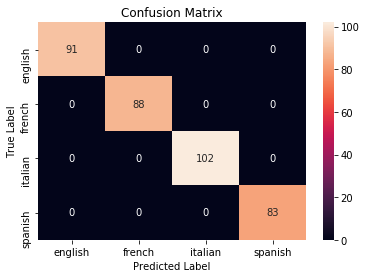

In [20]:
confusion_matrix_c(y_test.argmax(axis=1),predictions.argmax(axis=1))

# Testing Model on French Text

In [21]:
#these are the codes for each language in order to evaluate properly
print('english', encoder.transform(['english']))
print('french', encoder.transform(['french']))
print('italian', encoder.transform(['italian']))
print('spanish', encoder.transform(['spanish']))

english [0]
french [1]
italian [2]
spanish [3]


![Crazier out there](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ0mJ-YupJjR5-9DFSVZBh9TE6B_w13AtS9RF1CUc8tpKRPW37rjA&s)

In [22]:
en_new_text = ["Is it just me, or is it getting crazier out there?"]
fr_new_text = ["Est-ce juste moi, ou est-ce que ça devient de plus en plus fou?"]
it_new_text = ["Sono solo io, o sta diventando più pazzo là fuori?"]
es_new_text = ["¿Soy solo yo, o se está volviendo más loco por ahí?"]
new_text=[]
for i in [en_new_text,fr_new_text,it_new_text,es_new_text]:
    new_text.append(i)

In [23]:
new_text

[['Is it just me, or is it getting crazier out there?'],
 ['Est-ce juste moi, ou est-ce que ça devient de plus en plus fou?'],
 ['Sono solo io, o sta diventando più pazzo là fuori?'],
 ['¿Soy solo yo, o se está volviendo más loco por ahí?']]

In [24]:
new_text = pd.DataFrame(new_text)
new_text.columns = ['sentence']
new_text

,sentence
0,"Is it just me, or is it getting crazier out th..."
1,"Est-ce juste moi, ou est-ce que ça devient de ..."
2,"Sono solo io, o sta diventando più pazzo là fu..."
3,"¿Soy solo yo, o se está volviendo más loco por..."


In [25]:
new_text['sentence_lower'] = new_text["sentence"].str.lower()
new_text['sentence_no_punctuation'] = new_text['sentence_lower'].str.replace('[^\w\s]','')
new_text['sentence_no_punctuation'] = new_text["sentence_no_punctuation"].fillna("fillna")

In [26]:
np.set_printoptions(suppress=True)
test_text = tok.texts_to_sequences(list(new_text['sentence_no_punctuation'] )) 
test_text = tf.keras.preprocessing.sequence.pad_sequences(test_text, maxlen=maxlen)

In [27]:
predictions = model.predict(test_text)
print(predictions)
print(predictions.argmax(axis=1))
print(encoder.inverse_transform(predictions.argmax(axis=1)))
for i in predictions:
    new_text['language'] = encoder.inverse_transform(predictions.argmax(axis=1))

[[0.94042766 0.01730118 0.02512684 0.01714446]
 [0.05521378 0.63803834 0.04947681 0.25727102]
 [0.12121943 0.10470895 0.65658826 0.11748329]
 [0.0952154  0.11722024 0.16621105 0.6213533 ]]
[0 1 2 3]
['english' 'french' 'italian' 'spanish']


In [28]:
del new_text['sentence']
del new_text['sentence_lower']

In [29]:
new_text

,sentence_no_punctuation,language
0,is it just me or is it getting crazier out there,english
1,estce juste moi ou estce que ça devient de plu...,french
2,sono solo io o sta diventando più pazzo là fuori,italian
3,soy solo yo o se está volviendo más loco por ahí,spanish


# Testing Model on Random Wikipedia pages in Spanish 

In [30]:
import wikipedia

In [31]:
#language codes
#english: en
#italian: it
#french: fr
#spanish: es
new_wiki_text = []
wikipedia.set_lang('es')
for i in range(0, 5):
    print(i)
    random = wikipedia.random(1)
       
    try:
        new_wiki_text.append([wikipedia.page(random).summary])
    except wikipedia.exceptions.DisambiguationError as e:
        random = wikipedia.random(1)

0
1
2
3
4


In [32]:
new_wiki_text = pd.DataFrame(new_wiki_text)
new_wiki_text.columns = ['sentence']
new_wiki_text

,sentence
0,"Nydia Caro (Nueva York, 7 de junio de 1948) es..."
1,"Tania Lamarca Celada (Vitoria, España; 30 de a..."
2,"Malva Flores (Ciudad de México, 1961) es poeta..."
3,La Batalla de Juan Griego fue una batalla ocur...
4,South Ferry loops (bucles del South Ferry en e...


In [33]:
new_wiki_text['sentence_lower'] = new_wiki_text["sentence"].str.lower()
new_wiki_text['sentence_no_punctuation'] = new_wiki_text['sentence_lower'].str.replace('[^\w\s]','')
new_wiki_text['sentence_no_punctuation'] = new_wiki_text["sentence_no_punctuation"].fillna("fillna")

In [34]:
np.set_printoptions(suppress=True)
test_wiki_text = tok.texts_to_sequences(list(new_wiki_text['sentence_no_punctuation'] )) 
test_wiki_text = tf.keras.preprocessing.sequence.pad_sequences(test_wiki_text, maxlen=maxlen)

In [35]:
predictions = model.predict(test_wiki_text)
print(predictions)
print(predictions.argmax(axis=1))
print(encoder.inverse_transform(predictions.argmax(axis=1)))
for i in predictions:
    new_wiki_text['language'] = encoder.inverse_transform(predictions.argmax(axis=1))

[[0.00341583 0.00942457 0.00444568 0.9827139 ]
 [0.00000056 0.00006527 0.00000114 0.999933  ]
 [0.00000569 0.0001035  0.00002781 0.999863  ]
 [0.00001514 0.00055682 0.00006685 0.9993612 ]
 [0.00000043 0.00010282 0.0000007  0.99989605]]
[3 3 3 3 3]
['spanish' 'spanish' 'spanish' 'spanish' 'spanish']


In [36]:
del new_wiki_text['sentence']
del new_wiki_text['sentence_lower']

In [37]:
new_wiki_text

,sentence_no_punctuation,language
0,nydia caro nueva york 7 de junio de 1948 es un...,spanish
1,tania lamarca celada vitoria españa 30 de abri...,spanish
2,malva flores ciudad de méxico 1961 es poeta na...,spanish
3,la batalla de juan griego fue una batalla ocur...,spanish
4,south ferry loops bucles del south ferry en es...,spanish
